# Setup

In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Imports
import pickle
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

In [ ]:
# Matt setup
BASE_PATH = 'C:/Users/Matt/Dropbox/SnowComp/'
MODIS_PATH = BASE_PATH
DATA_PATH = 'C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/'
OUT_PATH = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/"
PRED_PATH = "C:/Users/Matt/Dropbox/SnowComp/preds/pred" 


# Isabella setup
DATA_PATH = 'drive/MyDrive/fall21/snowcast/data/'
BASE_PATH = DATA_PATH
MODIS_PATH = DATA_PATH + 'modis/'
DEM_PATH = DATA_PATH + 'elevation/'
OUT_PATH = DATA_PATH + 'nn_output/'
PRED_PATH = OUT_PATH


# Sentinel sandbox

In [ ]:
! ls $DATA_PATH/sentinel/sent_pp_ylabs.npy

ls: cannot access '/sentinel/sent_pp_ylabs.npy': No such file or directory


In [ ]:
#@title Installs
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal &> /dev/null
# Install rtree - Geopandas requirment
!apt install python3-rtree &> /dev/null
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git &> /dev/null
# Install descartes - Geopandas requirment
!pip install descartes &> /dev/null
!pip install geopandas rioxarray &> /dev/null

import geopandas as gpd

In [ ]:
#@title Original data
metadata = pd.read_csv(DATA_PATH + 'ground_measures_metadata.csv')
train_inp = pd.read_csv(DATA_PATH + 'ground_measures_train_features.csv')
test_inp = pd.read_csv(DATA_PATH + 'ground_measures_test_features.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
grid_cells = gpd.read_file(DATA_PATH + 'grid_cells.geojson')
submission_format = gpd.read_file(DATA_PATH + 'submission_format.csv')


In [ ]:
#@title Get metadata for grid cells
states = gpd.read_file(DATA_PATH + 'states/cb_2018_us_state_5m.shp')\
    .rename({'NAME': 'state'}, axis=1)
cell_metadata = gpd.sjoin(grid_cells, states[['geometry', 'state']])\
    .drop_duplicates(subset='cell_id')\
    .drop(['index_right'], axis=1)
cell_metadata['centroid'] = cell_metadata['geometry'].centroid
cell_metadata['longitude'] = cell_metadata['centroid'].x
cell_metadata['latitude'] = cell_metadata['centroid'].y
cell_metadata = cell_metadata[['cell_id', 'state', 'longitude', 'latitude']]

In [ ]:
#@title Format dfs
def get_rmse(df, actual='actual_snowpack', predicted='snowpack'):
    return ((df[actual] - df[predicted]) ** 2).mean() ** 0.5

def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def get_day_of_season(doy):
    return doy + 365 - 335 if doy < 335 else doy - 335

def add_time_cols(df):
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    df['dos'] = df['doy'].apply(get_day_of_season)
    df['year'] = df['date'].dt.year
    df['season'] = df['year']
    df.loc[df['doy'] < 335, 'season'] -= 1
    return df

def clean_train_test(df, id_col='station_id', metadata_df=None):
    df = pivot_df(df, id_col)
    if metadata_df is not None:
        df = df.merge(metadata_df)
    return add_time_cols(df)


train = clean_train_test(train_inp.rename({'Unnamed: 0': 'station_id'}, axis=1),
                         metadata_df=metadata)
train2 = clean_train_test(train_labels, 'cell_id', cell_metadata).dropna()
train_full = pd.concat([train2.rename({'cell_id': 'station_id'}, axis=1).assign(datatype='labels'),
                        train.drop(['elevation_m', 'name'], axis=1).assign(datatype='ground')])

test = clean_train_test(
    test_inp.rename({'Unnamed: 0': 'station_id'}, axis=1), metadata_df=metadata)\
    .rename({'snowpack': 'actual_snowpack'}, axis=1).dropna()\
    .merge(train[['station_id', 'state']].drop_duplicates())

to_predict = clean_train_test(submission_format.drop('geometry', axis=1), 'cell_id', cell_metadata)


In [ ]:
#@title Sentinel data
sent_path = DATA_PATH + 'sentinel/'

sentinel_trainfeat = np.load(sent_path + "sent_pp_trainfeat.npy")
sentinel_testfeat = np.load(sent_path + "sent_pp_testfeat.npy")
sentinel_ylabs = np.load(sent_path + "sent_pp_ylabs.npy")

trainfeat_meta = pd.read_csv(sent_path + "sent_trainfeat_meta.csv")
testfeat_meta = pd.read_csv(sent_path + "sent_testfeat_meta.csv")
ylabs_meta = pd.read_csv(sent_path + "sent_ylabs_meta.csv")


In [ ]:
#@title Sentinel data helpers
def y_merger(x, y):
    '''reattach y labels to sentinel'''
    y = y.rename(columns={"Unnamed: 0":"cell_id"})
    y = pivot_df(y, 'cell_id').dropna()
    y['date']=y['date'].map(daynum_gen)

    y['idx'] = y['cell_id'] + "-" + y['date']
    y = y.set_index('idx')

    x['idx'] = x['cell_id'] +\
         "-" +x['date_long'].astype(str)
    x = x.set_index('idx')

    return x.join(y['snowpack'])

def masker(x, y):
    mask = np.all(x > -99, axis = (1,2))
    print(mask.sum(), "of", len(mask))
    return x[mask], y[mask]

def minmaxscaler(x):
    print("min", round(x.min(),3), "max", round(x.max(),3))
    x = (x - x.min())/(x.max() - x.min())            
    return x

def reshaper(ds):
    dim0 = ds.shape[0]
    dim1 = ds.shape[1]
    dim2 = ds.shape[2]

    return ds.reshape((dim0, 1, dim1, dim2))

In [ ]:
sentinel_ylabs, ylabs_meta = masker(sentinel_ylabs, ylabs_meta)
sentinel_trainfeat, trainfeat_meta = masker(sentinel_trainfeat, trainfeat_meta)
sentinel_testfeat, testfeat_meta = masker(sentinel_testfeat, testfeat_meta)

sentinel_ylabs = minmaxscaler(sentinel_ylabs)
sentinel_trainfeat = minmaxscaler(sentinel_trainfeat)
sentinel_testfeat = minmaxscaler(sentinel_testfeat)

76159 of 76410
105571 of 106760
38618 of 38628
min -57.906 max 18.57
min -50.229 max 19.536
min -27.488 max 14.445


In [ ]:
dataset = np.concatenate([sentinel_trainfeat, sentinel_ylabs])
train_y = pd.concat([trainfeat_meta, ylabs_meta])
train_y['date'] = pd.to_datetime(train_y['date'])
train_y = train_y.merge(train_full.rename({'station_id': 'cell_id'}, axis=1)\
                                    [['cell_id', 'snowpack', 'date']])

testfeat_meta['date'] = pd.to_datetime(testfeat_meta['date'])
sentinel_ylab_test = testfeat_meta.merge(
    test.rename({'station_id': 'cell_id', 'actual_snowpack': 'snowpack'}, axis=1)\
    [['cell_id', 'snowpack', 'date']])



In [ ]:
# sentinel_testfeat, sentinel_ylab_test
del sentinel_ylabs
del ylabs_meta
del sentinel_trainfeat
del trainfeat_meta

# Basic pytorch CNN

In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_D = 1
START_HW = 41

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2, cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(START_D, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 3)
        
        #fourth layer
        print(cdim3, mp2_dim, mp2_dim)
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim', flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.tanh(x)
        # x = F.relu(x)
        
        output = self.fc2(x)
        return output

    




In [ ]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x = x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x, as_numpy = False)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)



In [ ]:
#@title Test run
cdim1=32; cdim2=18; cdim3 =8; kernel_sz=7; dropout=0.13; ldim=50
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)
optimizer = optim.Adam(my_nn.parameters(), lr=0.1)
optimizer.zero_grad()

# test_im = torch.from_numpy(dataset[0]).reshape(1, START_D, 21, 21)
test_im = torch.from_numpy(dataset[0]).reshape(1, START_D, 41, 41)
result = my_nn(test_im.type(torch.FloatTensor))
result.shape


8 17 17
c1 dim: 35
mp0 dim: 33
c2 dim: 27
mp1 dim: 25
c3 dim: 19
mp2 dim: 17
flattened_dim 2312


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([1, 1])

In [ ]:
#@title Get data loaders

mini_x = np.array(dataset.reshape(dataset.shape[0], 1, 41, 41))
mini_y = np.array(train_y['snowpack'])
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

test_x = np.array(sentinel_testfeat.reshape(sentinel_testfeat.shape[0], 1, 41, 41))
test_y = np.array(sentinel_ylab_test['snowpack'])
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size = 200)

mini_dataset = TensorDataset(mini_x, mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=200)

train_rows = len(mini_x)
test_rows = len(test_x)


In [ ]:
#@ title Setup net
cdim1, cdim2, cdim3, kernel_sz, dropout, ldim, lr = 32, 18, 8, 7, 0.13, 16, 1e-5
# cdim1, cdim2, cdim3, kernel_sz, dropout, ldim = 48, 18, 8, 3, 0.2, 50

my_nn = Net(cdim1=cdim1, cdim2=cdim2, cdim3=cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=lr)#0.00005)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/cnn_full')
write_index = 0


In [ ]:
#@title Run net
N_EPOCHS = 25

test_loss = []
train_loss = []
t0 = time.time()

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()

        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4),
          'elapsed:', round(time.time() - t0))
    
writer.close()
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 / 25 complete, train: 17.8807 test: 12.5302 elapsed: 52
1 / 25 complete, train: 17.8634 test: 12.5064 elapsed: 104
2 / 25 complete, train: 17.8078 test: 12.4681 elapsed: 156
3 / 25 complete, train: 17.6781 test: 12.4045 elapsed: 207
4 / 25 complete, train: 17.3874 test: 12.3193 elapsed: 259
5 / 25 complete, train: 17.0058 test: 12.2386 elapsed: 311
6 / 25 complete, train: 16.7382 test: 12.1689 elapsed: 363
7 / 25 complete, train: 16.5768 test: 12.1069 elapsed: 415
8 / 25 complete, train: 16.4674 test: 12.0495 elapsed: 467
9 / 25 complete, train: 16.3855 test: 11.995 elapsed: 519
10 / 25 complete, train: 16.3173 test: 11.9426 elapsed: 571
11 / 25 complete, train: 16.2572 test: 11.8918 elapsed: 623
12 / 25 complete, train: 16.202 test: 11.8424 elapsed: 675


In [ ]:
torch.cuda.empty_cache()
# 15.7-15.8


# Misc stuff you can probably ignore

## Checking accuracy

In [ ]:
# my_nn = my_nn.to('cpu')
# 

# print(np.sqrt(((vals.detach().numpy().flatten() - mini_y.numpy())**2).mean()))

In [ ]:
params = [cdim1, cdim1, cdim3, kernel_sz, dropout, ldim, epoch]
suffix = '_'.join([str(x) for x in params])

len(train_loss), len(test_loss),
epoch = len(train_loss) - 1

'48_48_8_3_0.2_50_44'

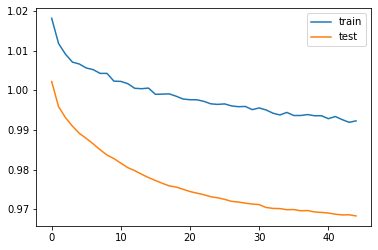

In [ ]:

plt.plot(range(epoch + 1), np.sqrt(train_loss), label = "train")
plt.plot(range(epoch + 1), np.sqrt(test_loss), label = "test")
plt.legend()
# plt.savefig(OUT_PATH + "converge_%s.png" % suffix)

(0.21107279569118523, 4.556924787190551e-92)
15.399050378626487


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


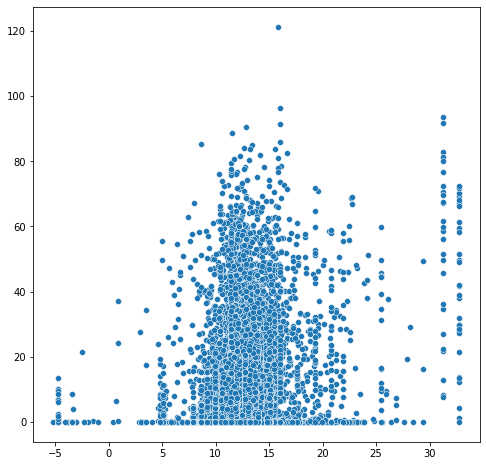

In [ ]:
from scipy.stats import pearsonr
import seaborn as sns

my_nn.eval()
preds = predict(my_nn.cuda(), test_x.cuda(), as_numpy=True)

preds_adj = preds * std + mean
gt_adj = test_y * std + mean

print(pearsonr(preds_adj, np.array(gt_adj)))
print(((preds_adj - np.array(gt_adj)) ** 2).mean() ** 0.5)

f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(preds_adj, gt_adj, ax=ax)

In [ ]:
my_nn.load_state_dict(torch.load(OUT_PATH + 'model48_48_8_3_0.2_50_44'))
# model.eval()

<All keys matched successfully>

In [ ]:
my_nn.eval()
my_nn.to('cpu')

torch.save(my_nn.state_dict(), OUT_PATH + "model" + suffix)

'drive/MyDrive/fall21/snowcast/data/nn_output/model48_48_8_3_0.2_50_44'

## Save Model and Predictions

In [ ]:
subset = dataset[int(dataset.shape[0] / 2):, :, :, :]
full_train_preds = predict(my_nn.cuda(), torch.Tensor(subset).cuda(), as_numpy=True)
np.save(PRED_PATH + 'preds1_' + suffix, full_train_preds)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
!ls $PRED_PATH/subpreds_$suffix

converge_32_32_8_3_0.13_50_2.png  model48_48_8_3_0.2_50_9
model32_32_8_3_0.13_50_2	  preds0_48_48_8_3_0.2_50_44.npy
model48_48_8_3_0.2_50_36	  preds1_48_48_8_3_0.2_50_44.npy
model48_48_8_3_0.2_50_44	  subpreds_48_48_8_3_0.2_50_44


In [ ]:
folds = 50
for i in range(folds):
    start = int(sub_dataset.shape[0] / folds) * i
    end = int(sub_dataset.shape[0] / folds) * (i + 1) if i < folds - 1 else sub_dataset.shape[0]

    subset = sub_dataset[start: end, :, :, :]
    full_train_preds = predict(my_nn.cuda(), torch.Tensor(subset).cuda(), as_numpy=True)
    np.save(PRED_PATH + 'subpreds_%s/%d' % (suffix, i) , full_train_preds)
    print(i)

(45745, 2, 21, 21)

In [ ]:
with torch.no_grad():
    vals = my_nn(mini_x).detach().numpy()


In [ ]:
np.save(PRED_PATH + suffix, vals)

In [ ]:
del mini_x, mini_dataset, mini_loader

sub_dataset = np.load(path5)

In [ ]:
#warning, very memory intensive (idk why)
with torch.no_grad():
    vals_sub = my_nn(sub_dataset).detach().numpy() 

TypeError: ignored

In [ ]:
np.save(PRED_PATH + "sub" + suffix, vals_sub)

## Things to check

1. Accuracy measures are right
2. Check missing value

### TODO:
- Add test set/cv
- Batchnorm?
- CNN benchmark